# 1. 이미지 분류를 위한 신경망

## 3) VGGNet

In [1]:
# 라이브러리 호출
import copy
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torch.utils.data as data
import torchvision
import torchvision.transforms as transforms
import torchvision.datasets as Datasets
import time

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [2]:
# VGG 모델 정의
class VGG(nn.Module):
    def __init__(self, features, output_dim):
        super().__init__()
        self.features = features
        self.avgpool = nn.AdaptiveAvgPool2d(7)
        self.classifier = nn.Sequential(
            nn.Linear(512*7*7, 4096),
            nn.ReLU(inplace=True),
            nn.Dropout(),
            nn.Linear(4096, 4096),
            nn.ReLU(inplace=True),
            nn.Dropout(),
            nn.Linear(4096, output_dim)
        ) # 완전연결층과 출력층 정의
    
    def forward(self, x):
        x = self.features(x)
        x = self.avgpool(x)
        h = x.view(x.shape[0], -1)
        x = self.classifier(h)
        return x, h

In [3]:
# 모델 유형 정의
# 합성곱층(8) + 풀링층(3) = 전체계층(11) = VGG11
vgg11_config = [64, 'M', 128, 'M', 256, 256, 'M', 512, 512, 'M', 512, 512, 'M']

# 합성곱층(10) + 풀링층(3) = 전체계층(13) = VGG13
vgg13_config = [64, 64, 'M', 128, 128, 'M', 256, 256, 'M', 512, 512, 'M', 512, 512, 'M']

# 합성곱층(13) + 풀링층(3) = 전체계층(16) = VGG16
vgg16_config = [64, 64, 'M', 128, 128, 'M', 256, 256, 256, 'M', 512, 512, 512, 'M', 512, 512, 512, 'M']

# 합성곱층(16) + 풀링층(3) = 전체계층(19) = VGG19
vgg19_config = [64, 64, 'M', 128, 128, 'M', 256, 256, 256, 256, 'M', 512, 512, 512, 512, 'M', 512, 512, 512, 512, 'M']

In [4]:
# VGG 계층 정의
def get_vgg_layers(config, batch_norm):
    layers = []
    in_channels = 3
    
    for c in config: # vgg config를 가지고 옴
        assert c == 'M' or isinstance(c, int)
        if c == 'M': # 불러온 값이 'M'일 경우, MaxPool2d 적용
            layers += [nn.MaxPool2d(kernel_size=2)]
        else: # 불러온 값이 int형일 경우, Conv2d 적용
            conv2d = nn.Conv2d(in_channels=in_channels, out_channels=c, kernel_size=3, padding=1)
            if batch_norm: # 배치정규화를 적용할지 말지
                layers += [conv2d, nn.BatchNorm2d(c), nn.ReLU(inplace=True)] # 배치정규화 적용시, '배치정규화 + ReLU'적용
            else:
                layers += [conv2d, nn.ReLU(inplace=True)] # 배치정규화 미적용시, 'ReLU'만 적용
            in_channels = c
            
    return nn.Sequential(*layers) # 네트워크의 모든 계층 반환

In [5]:
# assert 예시
a = 1
b = 2
assert a == 1 and b == 3 # error

AssertionError: 

In [6]:
assert a == 1 and b == 2 # OK

In [7]:
# isinstance() 예시
print(isinstance(1, int))
print(isinstance(1.2, int))
print(isinstance('deep learning', str))

True
False
True


In [8]:
# 모델 계층 생성
vgg11_layers = get_vgg_layers(vgg11_config, batch_norm=True)

In [9]:
# vgg11 계층 확인
vgg11_layers

Sequential(
  (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (2): ReLU(inplace=True)
  (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (4): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (5): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (6): ReLU(inplace=True)
  (7): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (8): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (9): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (10): ReLU(inplace=True)
  (11): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (12): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (13): ReLU(inplace=True)
  (14): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, cei

In [10]:
# VGG11 전체에 대한 네트워크
OUTPUT_DIM = 2 # 강아지 / 고양이
model = VGG(vgg11_layers, OUTPUT_DIM)
print(model)

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (4): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (5): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (6): ReLU(inplace=True)
    (7): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (8): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (10): ReLU(inplace=True)
    (11): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (12): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (13): ReLU(inplace=True)
    (14): MaxPool2d(ke

In [11]:
# VGG11 사전 훈련된 모델 사용
import torchvision.models as models
pretrained_model = models.vgg11_bn(pretrained=True)
print(pretrained_model)

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (4): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (5): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (6): ReLU(inplace=True)
    (7): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (8): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (10): ReLU(inplace=True)
    (11): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (12): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (13): ReLU(inplace=True)
    (14): MaxPool2d(ke

In [12]:
# 이미지 데이터 전처리
train_transforms = transforms.Compose([
    transforms.Resize((256, 256)),
    transforms.RandomRotation(5),
    transforms.RandomHorizontalFlip(0.5),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

test_transforms = transforms.Compose([
    transforms.Resize((256, 256)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

In [13]:
# ImageFolder를 이용하여 데이터셋 불러오기
train_path = './data/catanddog/train'
test_path = './data/catanddog/test'

train_dataset = Datasets.ImageFolder(
    train_path,
    transform = train_transforms
)
test_dataset = Datasets.ImageFolder(
    test_path,
    transform = test_transforms
)

print(len(train_dataset), len(test_dataset))

529 12


In [14]:
# train, val 데이터셋 분리
TRAIN_RATIO = 0.9
n_train_examples = int(len(train_dataset) * TRAIN_RATIO) # 전체 훈련 데이터 중, 90%를 훈련 데이터셋으로 사용
n_valid_examples = len(train_dataset) - n_train_examples # 전체 훈련 데이터 중, 10%를 검증 데이터셋으로 사용

train_data, valid_data = data.random_split(train_dataset, [n_train_examples, n_valid_examples])

In [15]:
# 검증 데이터 전처리
test_data = copy.deepcopy(valid_data)
test_data.dataset.transform = test_transforms

In [16]:
# train, val, test 데이터셋 개수 확인
print(f'Number of training examples: {len(train_data)}')
print(f'Number of validation examples: {len(valid_data)}')
print(f'Number of testing examples: {len(test_dataset)}')

Number of training examples: 476
Number of validation examples: 53
Number of testing examples: 12


In [17]:
# 데이터로더를 사용하여 메모리로 데이터 불러오기
BATCH_SIZE = 128
train_iterator = data.DataLoader(train_data, shuffle=True, batch_size=BATCH_SIZE) # 훈련 데이터셋은 임의로 섞어서 가지고옴
valid_iterator = data.DataLoader(valid_data, batch_size=BATCH_SIZE)
test_iterator = data.DataLoader(test_dataset, batch_size=BATCH_SIZE)

In [18]:
# 옵티마이저와 손실 함수 정의
optimizer = optim.Adam(model.parameters(), lr=1e-7)
criterion = nn.CrossEntropyLoss()

model = model.to(device)
criterion = criterion.to(device)

In [19]:
# 모델 정확도 측정 함수
def calculate_accuracy(y_pred, y):
    top_pred = y_pred.argmax(1, keepdim=True)
    correct = top_pred.eq(y.view_as(top_pred)).sum()
    acc = correct.float() / y.shape[0]
    return acc

In [20]:
# 모델 학습 함수 정의
def train(model, iterator, optimizer, criterion, device):
    epoch_loss = 0
    epoch_acc = 0
    
    model.train()
    for (x, y) in iterator:
        x = x.to(device)
        y = y.to(device)
        
        optimizer.zero_grad()
        y_pred, _ = model(x)
        loss = criterion(y_pred, y)
        acc = calculate_accuracy(y_pred, y)
        loss.backward()
        optimizer.step()
        
        epoch_loss += loss.item()
        epoch_acc += acc.item()
        
    return epoch_loss / len(iterator), epoch_acc / len(iterator)

In [21]:
# 모델 성능 측정 함수
def evaluate(model, iterator, criterion, device):
    epoch_loss = 0
    epoch_acc = 0
    
    model.eval()
    with torch.no_grad():
        for (x, y) in iterator:
            x = x.to(device)
            y = y.to(device)
            
            y_pred, _ = model(x)
            loss = criterion(y_pred, y)
            acc = calculate_accuracy(y_pred, y)
            
            epoch_loss += loss.item()
            epoch_acc += acc.item()
            
    return epoch_loss / len(iterator), epoch_acc / len(iterator)

In [22]:
# 학습 시간 측정 함수
def epoch_time(start_time, end_time):
    elapsed_time = end_time - start_time
    elapsed_mins = int(elapsed_time / 60)
    elapsed_secs = int(elapsed_time - (elapsed_mins*60))
    return elapsed_mins, elapsed_secs

In [23]:
# time 모듈 예시
import time
a = time.time()
a

1674198554.562879

In [24]:
b = time.time()
b

1674198554.5770423

In [25]:
c = b-a
c

0.01416325569152832

In [26]:
d = int(c / 60)
d

0

In [27]:
int(c - (d*60))

0

In [28]:
type(time.time())

float

In [29]:
# 모델 학습
# EPOCHS = 5
EPOCHS = 1
best_valid_loss = float('inf')
for epoch in range(EPOCHS):
    start_time = time.monotonic()
    train_loss, train_acc = train(model, train_iterator, optimizer, criterion, device)
    valid_loss, valid_acc = evaluate(model, valid_iterator, criterion, device)
    
    if valid_loss < best_valid_loss: # valid_loss가 가장 작은 값일 때
        best_valid_loss = valid_loss
        torch.save(model.state_dict(), './data/VGG-model.pt') # 그 상태의 모델을 VGG-model.pt 이름으로 저장
        
    end_time = time.monotonic()
    epoch_mins, epoch_secs = epoch_time(start_time, end_time)
    
    print(f'Epoch: {epoch+1:02} | Epoch Time: {epoch_mins}m {epoch_secs}s')
    print(f'\tTrain Loss: {train_loss:.3f} | Train Acc: {train_acc*100:.2f}%')
    print(f'\tValid. Loss: {valid_loss:.3f} | Valid. Acc: {valid_acc*100:.2f}%')

C:\Users\AIFFEL\miniconda3\envs\torch_book\lib\site-packages\torch\nn\functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  ..\c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)


Epoch: 01 | Epoch Time: 6m 37s
	Train Loss: 0.704 | Train Acc: 46.93%
	Valid. Loss: 0.691 | Valid. Acc: 58.49%


In [30]:
print(float('inf')) # 양의 무한대
print(float('-inf')) # 음의 무한대

inf
-inf


In [31]:
time.monotonic()

22752.562

In [32]:
# 테스트 데이터셋을 이용한 모델 성능 측정 (VGG-model.pt 사용)
model.load_state_dict(torch.load('./data/VGG-model.pt'))
test_loss, test_acc = evaluate(model, test_iterator, criterion, device)
print(f'Test Loss: {test_loss:.3f} | Test Acc: {test_acc*100:.2f}%')

Test Loss: 0.693 | Test Acc: 50.00%


In [33]:
# 데스트 데이터셋을 이용한 모델의 예측 확인 함수
def get_predictions(model, iterator):
    model.eval()
    images = []
    labels = []
    probs = []
    
    with torch.no_grad():
        for (x, y) in iterator:
            x = x.to(device)
            y_pred, _ = model(x)
            y_prob = F.softmax(y_pred, dim=-1)
            top_pred = y_prob.argmax(1, keepdim=True)
            images.append(x.cpu())
            labels.append(y.cpu())
            probs.append(y_prob.cpu())
    
    images = torch.cat(images, dim=0)
    labels = torch.cat(labels, dim=0)
    probs = torch.cat(probs, dim=0)
    return images, labels, probs

In [34]:
# torch.cat() 예시
import torch
x = torch.Tensor([[1,2,3], [2,3,4]])
y = torch.Tensor([[4,5,6], [5,6,7]])

print(torch.cat([x], dim=0)) # 행을 기준(dim=0)으로 x를 이어 붙임
print('-'*20)
print(torch.cat([x, y])) # 단순하게 x와 y를 결합
print('-'*20)
print(torch.cat([x, y], dim=0)) # 행을 기준(dim=0)으로 x와 y를 이어 붙임 → 행으로 추가
print('-'*20)
print(torch.cat([x, y], dim=1)) # 열을 기준(dim=1)으로 x와 y를 이어 붙임 → 열에 추가

tensor([[1., 2., 3.],
        [2., 3., 4.]])
--------------------
tensor([[1., 2., 3.],
        [2., 3., 4.],
        [4., 5., 6.],
        [5., 6., 7.]])
--------------------
tensor([[1., 2., 3.],
        [2., 3., 4.],
        [4., 5., 6.],
        [5., 6., 7.]])
--------------------
tensor([[1., 2., 3., 4., 5., 6.],
        [2., 3., 4., 5., 6., 7.]])


In [35]:
# 예측 중에서 정확하게 예측한 것을 추출
images, labels, probs = get_predictions(model, test_iterator)
pred_labels = torch.argmax(probs, 1)
corrects = torch.eq(labels, pred_labels) # 예측과 정답이 같은지 비교
correct_examples = []

for image, label, prob, correct in zip(images, labels, probs, corrects):
    if correct:
        correct_examples.append((image, label, prob))
    
correct_examples.sort(reverse=True, key=lambda x: torch.max(x[2], dim=0).values)

In [50]:
correct_examples[0]

(tensor([[[-0.1486, -0.1657, -0.1657,  ...,  1.2043,  1.3070,  1.3070],
          [-0.1486, -0.1486, -0.1657,  ...,  1.2214,  1.3070,  1.3070],
          [-0.1314, -0.1486, -0.1486,  ...,  1.2385,  1.3070,  1.3070],
          ...,
          [ 1.1700,  1.1700,  1.1700,  ..., -0.1486, -0.2684, -0.4054],
          [ 1.1700,  1.1700,  1.1700,  ..., -0.1486, -0.2513, -0.2856],
          [ 1.1700,  1.1700,  1.1700,  ..., -0.1314, -0.3198, -0.3541]],
 
         [[ 0.0651,  0.0476,  0.0476,  ...,  1.2906,  1.3431,  1.3431],
          [ 0.0651,  0.0651,  0.0476,  ...,  1.3081,  1.3431,  1.3431],
          [ 0.0826,  0.0651,  0.0651,  ...,  1.3081,  1.3431,  1.3431],
          ...,
          [ 1.2206,  1.2206,  1.2206,  ..., -0.2675, -0.3200, -0.4251],
          [ 1.2206,  1.2206,  1.2206,  ..., -0.2500, -0.3025, -0.3025],
          [ 1.2206,  1.2206,  1.2206,  ..., -0.2325, -0.3550, -0.3725]],
 
         [[ 0.1825,  0.1651,  0.1651,  ...,  1.3154,  1.3851,  1.3851],
          [ 0.1825,  0.1825,

In [36]:
# torch.argmax() 예시
x = torch.rand(5,3)
x

tensor([[0.4733, 0.3482, 0.3341],
        [0.1266, 0.4743, 0.8526],
        [0.9658, 0.7574, 0.6397],
        [0.5976, 0.6812, 0.7705],
        [0.6549, 0.6684, 0.1428]])

In [37]:
torch.max(x, 0) # dim=0

torch.return_types.max(
values=tensor([0.9658, 0.7574, 0.8526]),
indices=tensor([2, 2, 1]))

In [38]:
torch.argmax(x, 0) # dim=0

tensor([2, 2, 1])

In [39]:
torch.max(x, 1) # dim=0

torch.return_types.max(
values=tensor([0.4733, 0.8526, 0.9658, 0.7705, 0.6684]),
indices=tensor([0, 2, 0, 2, 1]))

In [40]:
torch.argmax(x, 1) # dim=1

tensor([0, 2, 0, 2, 1])

In [41]:
# torch.max() 예시
x = torch.randn([4,4])
x

tensor([[-0.4780, -0.2340,  0.8320, -0.1829],
        [ 2.0651, -1.9376,  0.5310,  0.5264],
        [ 0.4873, -1.0275,  1.2934, -0.5885],
        [-0.4869, -0.2443, -0.7012, -0.3656]])

In [42]:
max_elements, max_idxs = torch.max(x, dim=0)
print(max_elements)
print(max_idxs)

tensor([ 2.0651, -0.2340,  1.2934,  0.5264])
tensor([1, 0, 2, 1])


In [43]:
torch.max(x[:], dim=0)

torch.return_types.max(
values=tensor([ 2.0651, -0.2340,  1.2934,  0.5264]),
indices=tensor([1, 0, 2, 1]))

In [44]:
torch.max(x[2], dim=0)

torch.return_types.max(
values=tensor(1.2934),
indices=tensor(2))

In [46]:
# 이미지 출력을 위한 전처리
def normalize_image(image):
    image_min = image.min()
    image_max = image.max()
    image.clamp_(min=image_min, max=image_max) # torch.clamp는 주어진 최소, 최대의 범주에 이미지가 위치하도록 하는 함수
    image.add_(-image_min).div_(image_max-image_min+1e-5)
    return image

In [47]:
# torch.add()와 torch.add_()의 차이
x = torch.tensor([1, 2])
y = x.add(10) # torch.add() 적용
print(y)
print(x is y)
print('-'*20)
y = x.add_(10) # torch.add_()적용
print(y)
print(x is y)

tensor([11, 12])
False
--------------------
tensor([11, 12])
True


In [129]:
# 모델이 정확하게 예측한 이미지 출력 함수
from matplotlib import pyplot as plt

def plot_most_correct(correct, classes, n_images, normalize=True):
    rows = int(np.sqrt(n_images)) # np.sqrt()는 제곱근 계산
    cols = int(np.sqrt(n_images))
    fig = plt.figure(figsize=(25,20))
    for i in range(rows*cols):
        ax = fig.add_subplot(rows, cols, i+1)
        image, true_label, prob = correct[i]
        image = image.permute(1, 2, 0)
        true_prob = probs[true_label]
        correct_prob, correct_label = torch.max(probs, dim=0)
        true_class = classes[true_label]
        correct_class = classes[torch.argmax(correct_label, dim=0)]
        
        if normalize:
            image = normalize_image(image)
            
        ax.imshow(image.cpu().numpy())
        ax.set_title('true label: {} ({:.3f})\n pred label: {} ({:.3f})'.format(
            true_class, torch.max(true_prob), correct_class, torch.max(correct_prob)
        ))
        ax.axis('off')
        
    fig.subplots_adjust(hspace=0.4)

In [130]:
# image.permute() 예시
x = torch.tensor([[1,2,3],[4,5,6]])
x

tensor([[1, 2, 3],
        [4, 5, 6]])

In [131]:
x.permute(1, 0)

tensor([[1, 4],
        [2, 5],
        [3, 6]])

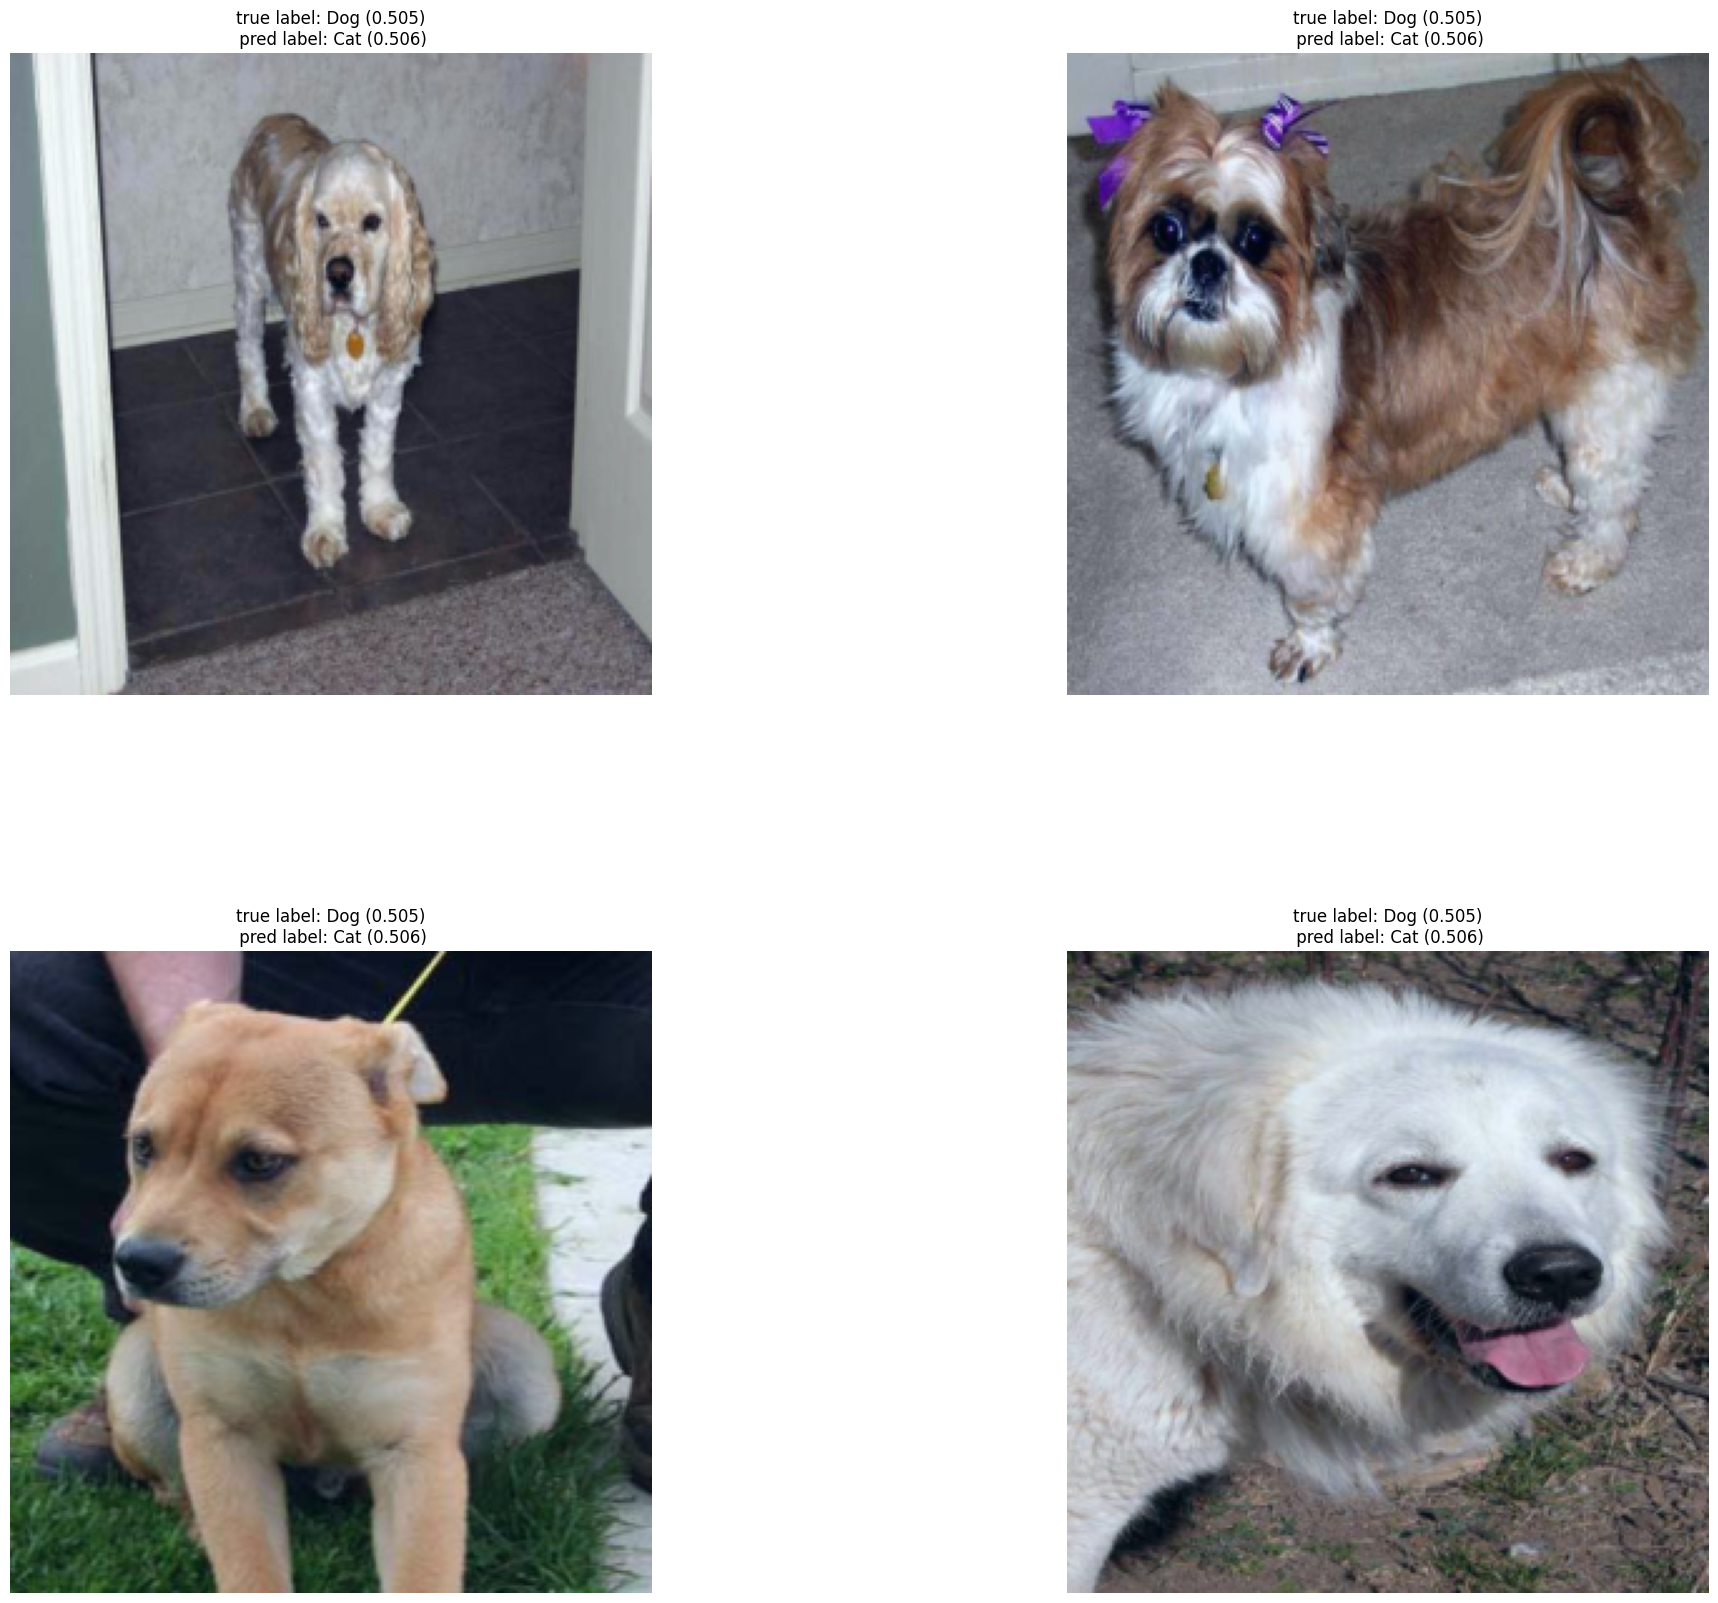

In [132]:
# 예측 결과 이미지 출력
classes = test_dataset.classes
N_IMAGES = 5
plot_most_correct(correct_examples, classes, N_IMAGES)